In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.1'
# spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

## import matplotlib, etc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## import seaborn for heatmap
import seaborn as sns; sns.set_theme()

## import gaussian filter to smooth heatmap
from scipy.ndimage.filters import gaussian_filter


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [44.4 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [2]:
# suppress warnings, if you want:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.18.jar").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url="https://markdatabucket.s3.amazonaws.com/cbb.csv"

spark.sparkContext.addFile(url)
spark_data_df = spark.read.csv(SparkFiles.get("cbb.csv"), sep=",", header=True, inferSchema=True)

cbb_df = spark_data_df.toPandas()

# Show DataFrame
cbb_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1,2017


In [5]:
# get list of relevant stats
allColumns = list(cbb_df.columns)
stats = allColumns[2:21]


In [6]:
# make main function to generate test scores for the particular year. Pass in theYear and stats (from dataframe header)
def cbbYearParser(stats, classifier):

    allYears = [2015, 2016, 2017, 2015, 2019]
    allTestScores = []
    for theYear in allYears:
      cbb_current_df = cbb_df[cbb_df.YEAR == theYear]
      cbb_current_df['POSTSEASON_BINARY'] = cbb_current_df['POSTSEASON']
      cbb_current_df['POSTSEASON_MULTI'] = cbb_current_df['POSTSEASON']

      # determine if team made it to the post season (0: no; 1: yes). Use a function
      cbb_current_df = postSeasonQuantifierBinary(cbb_current_df)
      cbb_current_df = postSeasonQuantifierMulti(cbb_current_df)

      # create an empty list to hold testScores
      allTestScores_oneYear = [] ;

      # #******************************************************
      # STATS:
      for stat in stats:
        testScore_OneStat = statPasser_LOGISTIC(stat, cbb_current_df, classifier) ;
        allTestScores_oneYear.append(testScore_OneStat)

      # append test scores
      allTestScores.append(allTestScores_oneYear)

    # convert allTestScores (python list) to a dataframe
    allTestScores_df = pd.DataFrame(allTestScores)
    allTestScores_df.columns = stats

    # make a dataframe holding the years
    years = ['2015', '2016', '2017', '2018', '2019']
    years_df = pd.DataFrame(years)
    years_df.columns = ['Year']

    # concatenate the years and stats dataframes
    testScore_df = pd.concat([years_df, allTestScores_df], axis=1).reindex(years_df.index)
    return testScore_df


In [7]:
# make function to quantify post-season outcome
def postSeasonQuantifierBinary(cbb_current_df):
  cbb_current_df.POSTSEASON_BINARY[cbb_current_df.POSTSEASON_BINARY == "NA"] = 0
  cbb_current_df.POSTSEASON_BINARY[cbb_current_df.POSTSEASON_BINARY != 0] = 1
  
  return cbb_current_df

In [8]:
def postSeasonQuantifierMulti(cbb_current_df):
  cbb_current_df.POSTSEASON_MULTI[cbb_current_df.POSTSEASON_MULTI == "NA"] = 0
  cbb_current_df.POSTSEASON_MULTI[cbb_current_df.POSTSEASON_MULTI == "R64"] = 1
  cbb_current_df.POSTSEASON_MULTI[cbb_current_df.POSTSEASON_MULTI == "R32"] = 2
  cbb_current_df.POSTSEASON_MULTI[cbb_current_df.POSTSEASON_MULTI == "S16"] = 3
  cbb_current_df.POSTSEASON_MULTI[cbb_current_df.POSTSEASON_MULTI == "E8"] = 4
  cbb_current_df.POSTSEASON_MULTI[cbb_current_df.POSTSEASON_MULTI == "F4"] = 5
  cbb_current_df.POSTSEASON_MULTI[cbb_current_df.POSTSEASON_MULTI == "2ND"] = 6
  cbb_current_df.POSTSEASON_MULTI[cbb_current_df.POSTSEASON_MULTI == "Champions"] = 7
  
  return cbb_current_df

In [9]:
# make function to generate logistic function for stat and post-season outcome for a particular year (as defined by the 'current' df)
def statPasser_LOGISTIC(stat, cbb_current_df, classifier):

  # Assign the data to X and y (note that the X variable changes according to the 'stat' argument sent to statPasser)
  X = cbb_current_df[stat].values.reshape(-1, 1)
  y = cbb_current_df.POSTSEASON_BINARY
  y=y.astype('int')

  # from sklearn.model_selection import train_test_split
  from sklearn.model_selection import train_test_split

  # split the data
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

  # Train the model to the data. 
  classifier.fit(X_train, y_train)

  # define variables to hold classifier scores
  trainingScore = classifier.score(X_train, y_train)
  testScore = classifier.score(X_test, y_test)

  return testScore



In [10]:
# import models to run
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import ExtraTreeClassifier
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model.ridge import RidgeClassifierCV
from sklearn.linear_model.ridge import RidgeClassifier
from sklearn.linear_model.passive_aggressive import PassiveAggressiveClassifier    
from sklearn.gaussian_process.gpc import GaussianProcessClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV

In [11]:
# Get test scores for each model (17 total models)
LOGISTIC_TestScores_df = cbbYearParser(stats, LogisticRegression())
DeTree_TestScores_df = cbbYearParser(stats, DecisionTreeClassifier())
LinearDiscriminantAnalysis_df = cbbYearParser(stats, LinearDiscriminantAnalysis())
KNeighborsClassifier_df = cbbYearParser(stats, KNeighborsClassifier())
GaussianNB_df = cbbYearParser(stats, GaussianNB())
ExtraTreeClassifier_df = cbbYearParser(stats, ExtraTreeClassifier())
MLPClassifier_df = cbbYearParser(stats, MLPClassifier())
GSGDClassifier_df = cbbYearParser(stats, SGDClassifier())
RidgeClassifierCV_df = cbbYearParser(stats, RidgeClassifierCV())
PassiveAggressiveClassifier_df = cbbYearParser(stats, PassiveAggressiveClassifier())
GaussianProcessClassifier_df = cbbYearParser(stats, GaussianProcessClassifier())
AdaBoostClassifier_df = cbbYearParser(stats, AdaBoostClassifier())
GradientBoostingClassifier_df = cbbYearParser(stats, GradientBoostingClassifier())
BaggingClassifier_df = cbbYearParser(stats, BaggingClassifier())
RandomForestClassifier_df = cbbYearParser(stats, RandomForestClassifier())
BernoulliNB_df = cbbYearParser(stats, BernoulliNB())
CalibratedClassifierCV_df = cbbYearParser(stats, CalibratedClassifierCV())

In [12]:
# concatenate all score dataframes
allScores = [LOGISTIC_TestScores_df, DeTree_TestScores_df, LinearDiscriminantAnalysis_df, KNeighborsClassifier_df, GaussianNB_df,
             ExtraTreeClassifier_df, MLPClassifier_df, GSGDClassifier_df, RidgeClassifierCV_df, PassiveAggressiveClassifier_df, 
             GaussianProcessClassifier_df, AdaBoostClassifier_df, GradientBoostingClassifier_df,  BaggingClassifier_df,  RandomForestClassifier_df,
             BernoulliNB_df, CalibratedClassifierCV_df]
allModelScores_df = pd.concat(allScores)


In [13]:
# reduce dataframe to the (likely) relevant metrics
relevantModelScores_df = allModelScores_df.iloc[:,3:18]
relevantModelScores_df.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D
0,0.943182,0.863636,0.875000,0.818182,0.772727,0.795455,0.784091,0.784091,0.784091,0.784091,0.784091,0.806818,0.829545,0.772727,0.761364
1,0.818182,0.875000,0.863636,0.818182,0.829545,0.795455,0.784091,0.784091,0.784091,0.784091,0.784091,0.784091,0.795455,0.795455,0.784091
2,0.909091,0.863636,0.897727,0.795455,0.784091,0.784091,0.784091,0.784091,0.784091,0.784091,0.784091,0.795455,0.772727,0.806818,0.795455
3,0.943182,0.863636,0.875000,0.818182,0.772727,0.795455,0.784091,0.784091,0.784091,0.784091,0.784091,0.806818,0.829545,0.772727,0.761364
4,0.898876,0.898876,0.842697,0.786517,0.853933,0.786517,0.786517,0.786517,0.786517,0.786517,0.786517,0.797753,0.876404,0.764045,0.797753


In [14]:
LOGISTIC_TestScores_df = cbbYearParser(stats, LogisticRegression())
DeTree_TestScores_df = cbbYearParser(stats, DecisionTreeClassifier())
LinearDiscriminantAnalysis_df = cbbYearParser(stats, LinearDiscriminantAnalysis())
KNeighborsClassifier_df = cbbYearParser(stats, KNeighborsClassifier())
GaussianNB_df = cbbYearParser(stats, GaussianNB())
ExtraTreeClassifier_df = cbbYearParser(stats, ExtraTreeClassifier())
MLPClassifier_df = cbbYearParser(stats, MLPClassifier())
GSGDClassifier_df = cbbYearParser(stats, SGDClassifier())
RidgeClassifierCV_df = cbbYearParser(stats, RidgeClassifierCV())
PassiveAggressiveClassifier_df = cbbYearParser(stats, PassiveAggressiveClassifier())
GaussianProcessClassifier_df = cbbYearParser(stats, GaussianProcessClassifier())
AdaBoostClassifier_df = cbbYearParser(stats, AdaBoostClassifier())
GradientBoostingClassifier_df = cbbYearParser(stats, GradientBoostingClassifier())
BaggingClassifier_df = cbbYearParser(stats, BaggingClassifier())
RandomForestClassifier_df = cbbYearParser(stats, RandomForestClassifier())
BernoulliNB_df = cbbYearParser(stats, BernoulliNB())
CalibratedClassifierCV_df = cbbYearParser(stats, CalibratedClassifierCV())

In [15]:
# make y axis labels for heat map
y_axis_labels = ['','','LogisticRegression','','',
                 '','','DecisionTreeClassifier','','',
                 '','','LinearDiscriminantAnalysis','','',
                 '','','KNeighborsClassifier','','',
                 '','','GaussianNB','','',
                 '','','ExtraTreeClassifier','','',
                 '','','MLPClassifier','','','',
                 '','','SGDClassifier','','',
                 '','','RidgeClassifierCV','','',
                 '','','PassiveAggressiveClassifier','','',
                 '','','GaussianProcessClassifier','','',
                 '','','AdaBoostClassifier','','',
                 '','','GradientBoostingClassifier','','',
                 '','','BaggingClassifier','','',
                 '','','RandomForestClassifier','','',
                 '','','BernoulliNB','','',
                 '','','CalibratedClassifierCV','','',]


In [16]:
# import RC params so that figure size can be changed
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 20,20
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

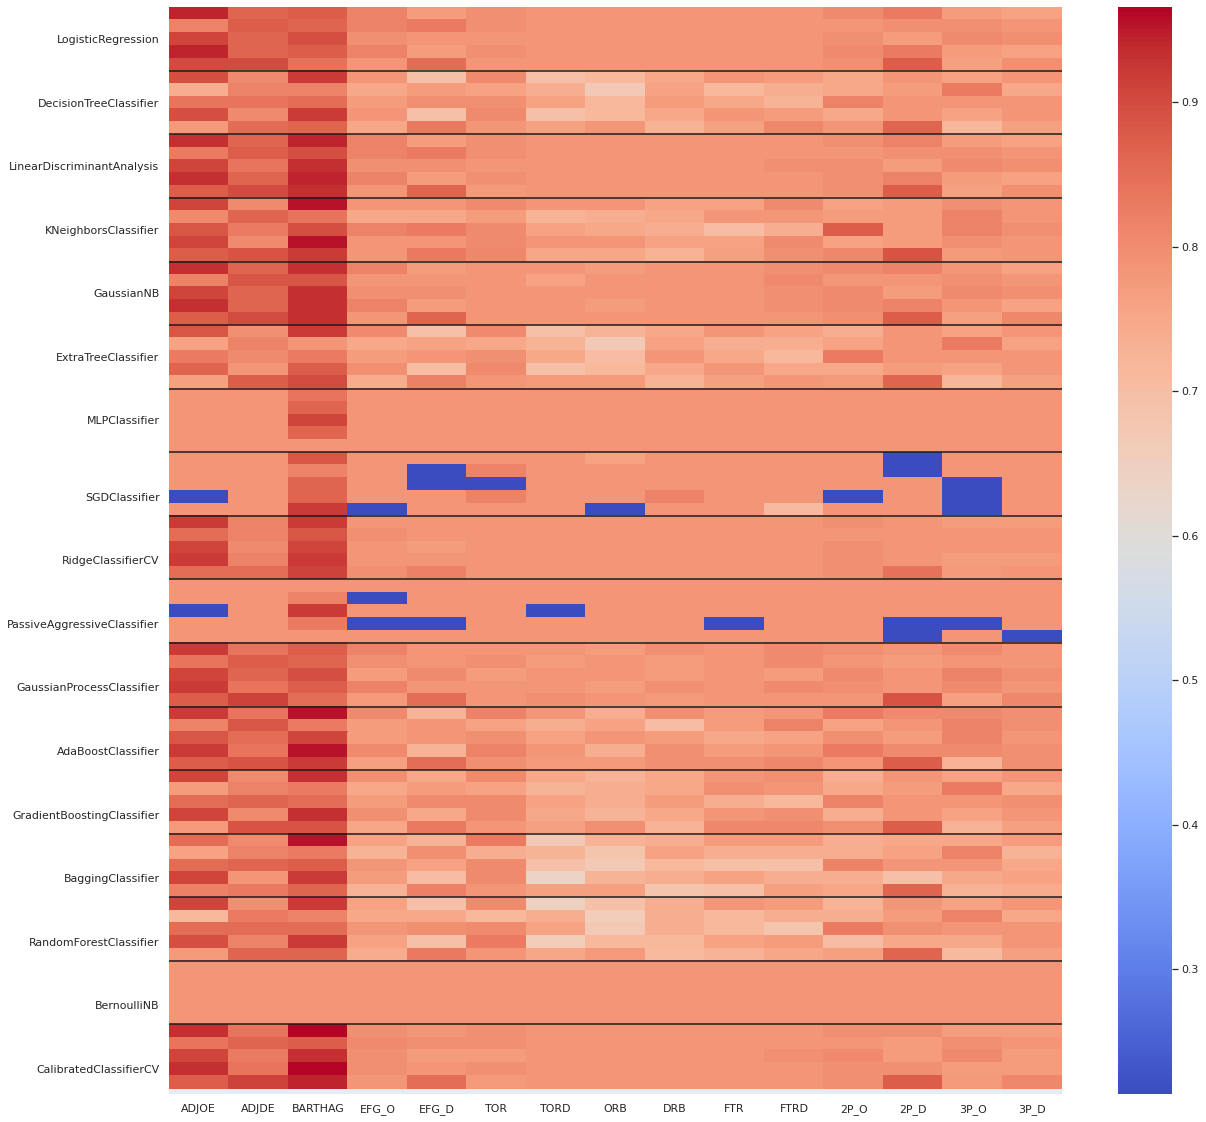

In [17]:
# make heat map
heatMapFig = sns.heatmap(relevantModelScores_df,cmap ="coolwarm", yticklabels=y_axis_labels)
lineList = list(range(5,85,5))
heatMapFig.hlines(lineList, *heatMapFig.get_xlim())
heatFigFinal = heatMapFig.get_figure()
heatFigFinal.savefig("heatMapScores.png")

# import so you can download fig
from google.colab import files
files.download("heatMapScores.png")

In [18]:
# select good classifier and create dataframe for confusion matrix
cbb_current_df = cbb_df[cbb_df.YEAR == 2015]

cbb_current_df['POSTSEASON_BINARY'] = cbb_current_df['POSTSEASON']
cbb_current_df['POSTSEASON_MULTI'] = cbb_current_df['POSTSEASON']

cbb_current_df = postSeasonQuantifierBinary(cbb_current_df)
cbb_current_df = postSeasonQuantifierMulti(cbb_current_df)

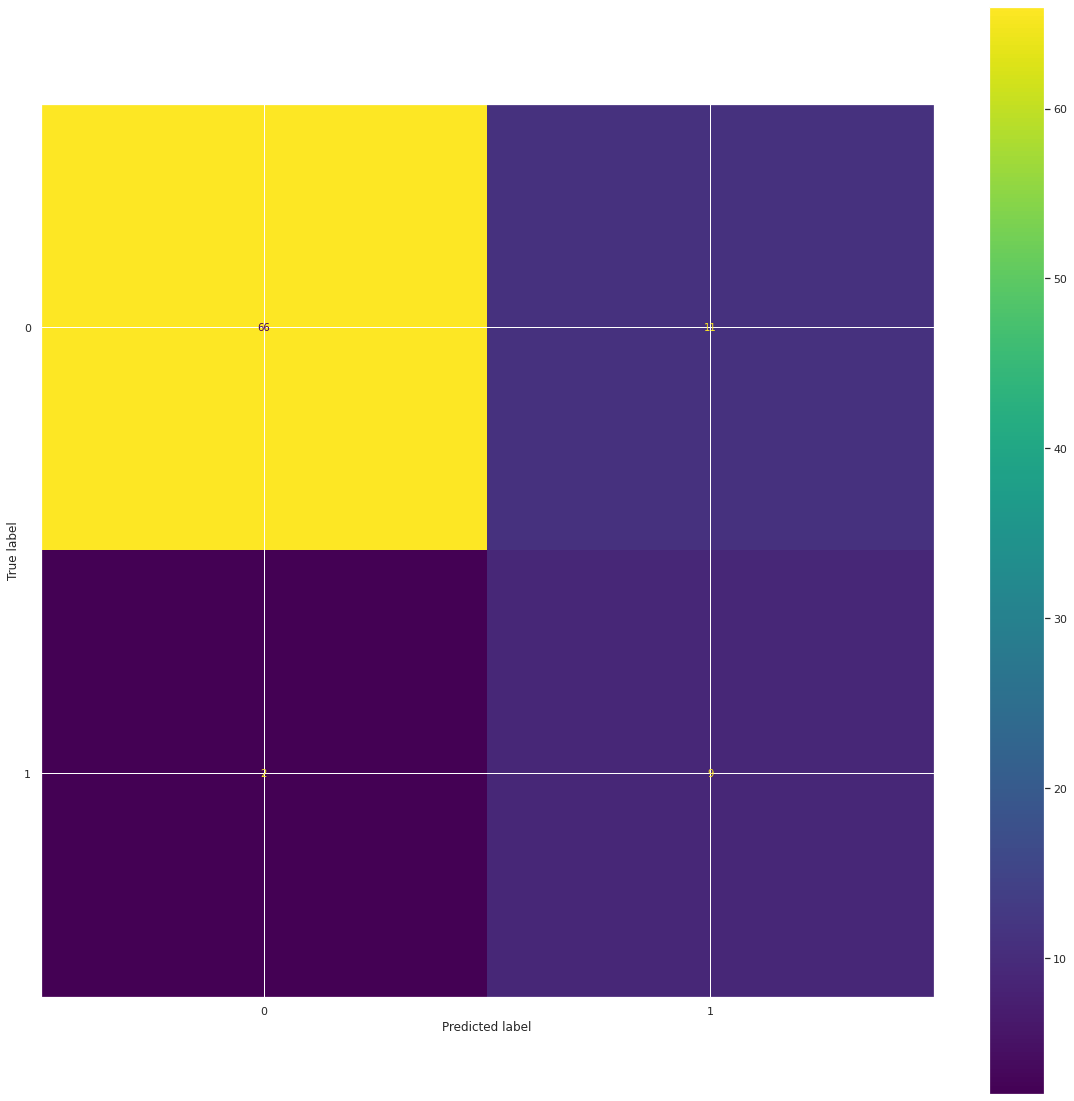

In [19]:
# make confusion matrix
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

X = cbb_current_df['BARTHAG'].values.reshape(-1, 1)
y = cbb_current_df.POSTSEASON_BINARY
y=y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = CalibratedClassifierCV()
clf.fit(X_train, y_train)
# SVC(random_state=0)
confMatrix = plot_confusion_matrix(clf, X_test, y_test)  
plt.show()


In [28]:
LOGISTIC_TestScores_df = pd.DataFrame

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [23]:
from pandas.io.formats.csvs import CSVFormatter

In [27]:

LOGISTIC_TestScores_df.to_csv('content/drive/My Drive/MyFolders/LOGISTIC_TestScores.csv')
#/c/Users/brend/OneDrive/Desktop/repos/Final-Project
#MyDF.to_csv('drive/My Drive/MyFolders/MyDF.csv')

AttributeError: ignored